In [1]:
import sys
sys.path.append('/usr/lib/python3/dist-packages')
import os
import pandas as pd
import datetime
import numpy as np
import json
#import shapefile
#from shapely.geometry  import Point, LineString, Polygon, MultiPolygon
from django.conf import settings
#from sqlalchemy import create_engine
os.environ["DJANGO_SETTINGS_MODULE"] = "mysite.settings"
import django
django.setup()
from tqdm import tqdm_notebook, tqdm
import glob
from django.db.models import Q, Sum, Avg
from pyproj import Proj, transform
PROJ3857  = Proj("+init=EPSG:3857")
PROJ4326 = Proj("+init=EPSG:4326")

/home/tserekh/env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
from main_map.models import OrganizationNatClass, TimeSquare, AlcoStopper
import itertools

In [3]:
df = pd.DataFrame(list(AlcoStopper.objects.all().values()))

In [4]:
import requests

In [5]:
SERVER_URL = 'http://178.62.250.186'
#SERVER_URL = 'http://127.0.0.1'

In [6]:
SERVER_URL_MSK_DRIVING = SERVER_URL + ':5000/table/v1/driving/'
SERVER_URL_MSK_FOOT =  'http://0.0.0.0:5001/table/v1/foot/'
SERVER_URL_PETER_DRIVING = SERVER_URL + ':5002/table/v1/driving/'
SERVER_URL_PETER_FOOT = SERVER_URL + ':5003/table/v1/foot/'
SERVER_URL_MSK_DRIVING = 'http://0.0.0.0:6000/table/v1/driving/'

In [7]:
import math

In [8]:
# def get_time_3000(lon, lat, coords, root_url):
#     page_url = root_url + '{},{};'.format(lon, lat)
    
#     times = []
#     for coord in coords:
#         page_url = page_url + '{},{};'.format(coord[0], coord[1])
#     page_url = page_url[:-1] + '?sources=0'
#     print(page_url)
#     page = requests.get(page_url)
#     data = page.json()
#     if 'durations' in data:
#         times.extend(data['durations'][0][1:])
#     else:
#         print('no key name duration in data from osrm')
#         times.extend([0]*len(coords))
#     return times
def get_time(lon, lat, coords, mode):

    root_url = {
        'driving': SERVER_URL_MSK_DRIVING,
        'foot': SERVER_URL_MSK_FOOT,
        }[mode]

    times = []
    if len(coords) < 3000:
        times.extend(get_time_3000(lon,lat, coords, root_url))
    else:
        for coord_chunk in tqdm_notebook(np.array_split(coords, len(coords) / 3000)):
            times.extend(get_time_3000(lon, lat, coord_chunk, root_url))

    # Заменить все None на нули
    times = [0 if i is None else i for i in times]
    return times

def get_time_3000(lon, lat, coords, root_url):
    page_url = root_url + '{},{};'.format(lat, lon)
    times = []
    for coord in coords:
        page_url = page_url + '{},{};'.format(coord[0], coord[1])
    page_url = page_url[:-1] + '?sources=0'
    #print(page_url)
    page = requests.get(page_url)
    #print(page)
    data = page.json()
#     print(data)
    if 'durations' in data:
        times.extend(data['durations'][0][1:])
#         times.extend([i['distance'] for i in data['destinations'][1:]])
    else:
        print('no key name duration in data from osrm')
        times.extend([0]*len(coords))
    return times


def get_time(lon, lat, coords, mode):
    try:
        # Проверка на Питер
        if lat > 58 and lat > 58:
            root_url = {
                'driving': SERVER_URL_PETER_DRIVING,
                'foot': SERVER_URL_PETER_FOOT,
                }[mode]
        else:
            root_url = {
                'driving': SERVER_URL_MSK_DRIVING,
                'foot': SERVER_URL_MSK_FOOT,
                }[mode]
    except KeyError as e:
        raise ValueError('Undefined mode: {}'.format())
    times = []
    if len(coords) < 3000:
        times.extend(get_time_3000(lon,lat, coords, root_url))
    else:
        for coord_chunk in tqdm_notebook(np.array_split(coords, len(coords) / 3000)):
            times.extend(get_time_3000(lon, lat, coord_chunk, root_url))

    # Заменить все None на нули
    times = [0 if i is None else i for i in times]
    return times

def get_coord_time(x, y, step, rmax, mode):
    coords = get_coords(x, y, step, rmax)
    lat, lon = transform(PROJ3857, PROJ4326, x, y)
    times = get_time(lon, lat, coords, mode)
    coords = list(map(lambda coord: transform(PROJ4326, PROJ3857, coord[0], coord[1]), coords))
    return coords, times

def get_coords(x, y, step, rmax):
    coords = itertools.product(np.arange(round(step*((x - rmax) // step)), round(step*((x + rmax) // step)), step),
                               np.arange(round(step*((y - rmax) // step)), round(step*((y + rmax) // step)), step))
    coords = list(coords)
    #print(len(list(coords)))
    #print(list(coords)[0])
    coords = list(map(lambda coord: transform(PROJ3857, PROJ4326, coord[0], coord[1]), coords))
    #print(coords)
    return coords

In [9]:
from collections import Counter
from shapely.geometry import Polygon

In [10]:
def make_polygon(lat, lon, step=10, rmax=100):
    x, y = transform(PROJ4326, PROJ3857, lon, lat)
    half_s = int(step/2)
    mode = 'foot'
    coords, times = get_coord_time(x, y, step, rmax*3, mode)
    df = pd.DataFrame(coords, times).reset_index()
    print(len(df))
    df.columns = ['distance', 'x', 'y']
    df['distance'] = df['distance'] * 1.388
    df = df[df['distance'] < rmax]

    df['x'] = df['x'].round(0).astype(int)
    df['y'] = df['y'].round(0).astype(int)
    df['polygon'] = df.apply(lambda r :[
                                ((r['x'] - half_s, r['y'] - half_s), (r['x'] - half_s, r['y'] + half_s)),
                                ((r['x'] - half_s, r['y'] + half_s), (r['x'] + half_s, r['y'] + half_s)),
                                ((r['x'] + half_s, r['y'] - half_s), (r['x'] + half_s, r['y'] + half_s)),
                                ((r['x'] - half_s, r['y'] - half_s), (r['x'] + half_s, r['y'] - half_s))], axis=1)
    out = []
    for i in df['polygon'].tolist():
        out.extend(i)
#     print(out)
    c = Counter()
    for i in out:
        c[i] += 1
    out = []

    for i in c:
        if c[i] == 1:
            out.append(i)
    polygon = []
    one = out[-1][0]
    out.pop()
    incr = 0
    print(len(out))
    polygon.append(one)
    while len(out) > 0:
        incr += 1
        if incr > 10000:
            break
        for i in out:
            if i[0] == one:
                one = i[1]
                polygon.append(one)
                out.remove(i)
                break
            if i[1] == one:
                one = i[0]
                polygon.append(one)
                out.remove(i)
                break
    print(len(polygon))
    return Polygon(polygon)

In [11]:
import geojson

In [12]:
from main_map.models import TimePolygons

In [13]:
len(df)

18465

In [14]:
# transform(PROJ3857, PROJ4326, a['geometry'].values[0])

In [15]:
# df

In [16]:
cafe = 1

In [17]:
df = df[df['cafe'] == cafe].reset_index(drop=True)

In [18]:
len(df)

8366

In [ ]:
out = []
for ind, row in df[df['cafe'] == cafe].loc[1122:].iterrows():
    print(ind)
    lat, lon = row['lat'], row['lon']
    x, y = transform(PROJ4326, PROJ3857, lon, lat)
    pol = make_polygon(lat, lon, step=4, rmax=25)
#     break
    obj = TimePolygons(x=x, y=y, geojson=geojson.dumps(pol), cafe=cafe, alco_stopper_id=row['id'])
#     out.append({'x': x, 'y': y, 'geometry': pol, 'ind': ind, 'lat': lat, 'lon': lon, 
#                 'name': row['Название'], 'id': row['ID на Яндекс.Карты']})
    obj.save()

1122
1369
79
80
1123
1369
85
86
1124
1444
111
112
1125
1444
95
96
1126
1406
89
90
1127
1369
107
108
1128
1406
91
92
1129
1406
79
80
1130
1406
89
90
1131
1406
101
102
1132
1369
85
86
1133
1406
127
128
1134
1444
113
114
1135
1406
101
102
1136
1406
101
102
1137
1444
103
104
1138
1406
83
84
1139
1369
101
102
1140
1369
109
110
1141
1444
111
112
1142
1369
65
66
1143
1406
93
94
1144
1444
87
88
1145
1406
93
94
1146
1406
79
80
1147
1406
85
86
1148
1406
115
116
1149
1406
107
108
1150
1369
73
74
1151
1369
107
108
1152
1406
89
90
1153
1406
97
98
1154
1406
89
90
1155
1406
91
92
1156
1406
77
78
1157
1369
99
100
1158
1369
109
110
1159
1369
81
82
1160
1369
125
126
1161
1406
87
88
1162
1369
71
72
1163
1406
89
90
1164
1406
105
106
1165
1369
61
62
1166
1406
75
76
1167
1406
93
94
1168
1406
59
60
1169
1369
99
100
1170
1406
95
96
1171
1444
103
104
1172
1444
81
82
1173
1444
91
92
1174
1406
109
110
1175
1369
103
104
1176
1444
89
90
1177
1406
111
112
1178
1406
81
82
1179
1406
85
86
1180
1406
95
96
1181
1406
10

1444
99
100
1671
1444
81
82
1672
1369
91
92
1673
1406
91
92
1674
1369
113
114
1675
1406
93
94
1676
1406
73
74
1677
1406
119
120
1678
1444
129
130
1679
1369
115
116
1680
1406
109
110
1681
1406
107
108
1682
1406
93
94
1683
1444
91
92
1684
1406
115
116
1685
1406
89
90
1686
1369
65
66
1687
1406
101
102
1688
1369
103
104
1689
1444
87
88
1690
1406
87
88
1691
1369
83
84
1692
1369
111
112
1693
1406
97
98
1694
1406
81
82
1695
1369
89
90
1696
1406
85
86
1697
1406
77
78
1698
1406
149
150
1699
1406
81
82
1700
1444
113
114
1701
1406
87
88
1702
1369
97
98
1703
1406
129
130
1704
1406
101
102
1705
1406
101
102
1706
1444
93
94
1707
1369
97
98
1708
1444
81
82
1709
1369
121
122
1710
1369
97
98
1711
1406
69
70
1712
1406
79
80
1713
1369
119
120
1714
1369
97
98
1715
1406
73
74
1716
1406
77
78
1717
1369
83
84
1718
1406
109
110
1719
1406
105
106
1720
1369
109
110
1721
1406
81
82
1722
1444
107
108
1723
1444
131
132
1724
1444
97
98
1725
1369
145
146
1726
1369
121
122
1727
1444
141
142
1728
1369
93
94
1729
1406


1369
149
150
2154
1406
139
140
2155
1406
67
68
2156
1444
143
144
2157
1444
107
108
2158
1444
107
108
2159
1406
125
126
2160
1444
85
86
2161
1444
147
148
2162
1406
109
110
2163
1406
123
124
2164
1369
103
104
2165
1369
119
120
2166
1369
91
92
2167
1369
147
148
2168
1406
121
122
2169
1406
87
88
2170
1406
85
86
2171
1369
119
120
2172
1444
101
102
2173
1406
97
98
2174
1369
75
76
2175
1406
121
122
2176
1406
109
110
2177
1406
105
106
2178
1369
147
148
2179
1444
115
116
2180
1444
145
146
2181
1444
85
86
2182
1444
151
152
2183
1444
141
142
2184
1406
103
104
2185
1444
133
134
2186
1444
105
106
2187
1444
123
124
2188
1444
131
132
2189
1444
123
124
2190
1406
113
114
2191
1406
71
72
2192
1406
111
112
2193
1444
119
120
2194
1406
107
108
2195
1369
103
104
2196
1406
123
124
2197
1369
117
118
2198
1444
141
142
2199
1406
87
88
2200
1369
93
94
2201
1369
123
124
2202
1444
135
136
2203
1406
149
150
2204
1406
99
100
2205
1369
85
86
2206
1369
97
98
2207
1406
83
84
2208
1406
149
150
2209
1406
109
110
2210
136

1369
117
118
2629
1406
93
94
2630
1444
101
102
2631
1444
113
114
2632
1406
69
70
2633
1369
75
76
2634
1444
59
60
2635
1444
113
114
2636
1406
85
86
2637
1444
115
116
2638
1444
101
102
2639
1444
135
136
2640
1406
89
90
2641
1444
87
88
2642
1406
93
94
2643
1406
115
116
2644
1444
111
112
2645
1406
97
98
2646
1444
85
86
2647
1406
89
90
2648
1444
115
116
2649
1406
129
130
2650
1406
91
92
2651
1369
95
96
2652
1406
105
106
2653
1444
69
70
2654
1369
89
90
2655
1369
109
110
2656
1444
103
104
2657
1369
83
84
2658
1406
99
100
2659
1406
93
94
2660
1406
101
102
2661
1406
87
88
2662
1444
89
90
2663
1406
95
96
2664
1406
93
94
2665
1406
81
82
2666
1444
117
118
2667
1406
69
70
2668
1369
95
96
2669
1406
111
112
2670
1444
67
68
2671
1406
91
92
2672
1406
57
58
2673
1444
69
70
2674
1369
111
112
2675
1406
137
138
2676
1369
103
104
2677
1406
77
78
2678
1444
75
76
2679
1369
93
94
2680
1369
83
84
2681
1369
69
70
2682
1444
81
82
2683
1406
127
128
2684
1406
81
82
2685
1444
109
110
2686
1406
85
86
2687
1406
93
94


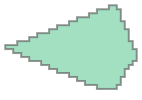

In [20]:
pol

In [265]:
import geopandas as gpd
a = gpd.GeoDataFrame(out,geometry='geometry', crs={'init': 'epsg:3857'})
a = a.to_crs(epsg=4326)
a.to_csv('../polygons.csv')

In [283]:
out = []
for ind, row in df.iloc[:30].iterrows():
    lat, lon = row['lat'], row['lon']
    x, y = transform(PROJ4326, PROJ3857, lon, lat)
    pol = make_polygon(lat, lon, step=2, rmax=25)
#     obj = TimePolygons(x=x, y=y, geojson=geojson.dumps(pol), cafe=0)
    out.append({'x': x, 'y': y, 'geometry': pol, 'ind': ind, 'lat': lat, 'lon': lon, 
                'name': row['Название'], 'id': row['ID на Яндекс.Карты']})
#     obj.save()


5625
205
206



5625
205
206



5625
245
246



5625
197
198



5625
157
158



5625
173
174



5625
181
182



5625
203
204



5625
179
180



5625
131
132



5625
187
188



5625
199
200



5625
171
172



5625
169
170



5625
207
208



5625
161
162



5625
197
198



5625
159
160



5625
123
124



5625
263
264



5625
279
280



5625
221
222



5625
251
252



5625
187
188



5625
205
206



5625
223
224



5625
223
224



5625
197
198



5625
205
206



5625
187
188


In [284]:
import geopandas as gpd
a = gpd.GeoDataFrame(out,geometry='geometry', crs={'init': 'epsg:3857'})
a = a.to_crs(epsg=4326)
a.to_csv('../polygons.csv')

In [285]:
a

,geometry,id,ind,lat,lon,name,x,y
0,"POLYGON ((37.85869814861437 55.74320015843412,...",1.245905e+09,0,55.743066,37.858114,Родник,4.214346e+06,7.507436e+06
1,"POLYGON ((37.83000595843959 55.81905687306637,...",1.113551e+09,1,55.818700,37.829347,"Лицей № 1598, корпус № 2",4.211144e+06,7.522408e+06
2,"POLYGON ((37.83336565760219 55.81859256382891,...",1.295907e+09,2,55.818360,37.832712,Лицей № 1598 Дошкольное отделение,4.211518e+06,7.522341e+06
3,"POLYGON ((37.82991612691117 55.82456759868279,...",1.376675e+11,3,55.824555,37.829524,"Лицей № 1598, корпус № 1",4.211163e+06,7.523569e+06
4,"POLYGON ((37.85055941214024 55.73793077975403,...",1.041883e+09,4,55.737821,37.850150,Я-ты-мы-они,4.213459e+06,7.506399e+06
5,"POLYGON ((37.8827370656174 55.71237280142892, ...",1.025436e+09,5,55.712271,37.882216,Hello world,4.217029e+06,7.501349e+06
6,"POLYGON ((37.82317876228027 55.7498743575126, ...",1.559768e+10,6,55.749800,37.823026,KidsBrain,4.210440e+06,7.508768e+06
7,"POLYGON ((37.88248553733784 55.71283837734882,...",2.153467e+11,7,55.712495,37.882120,Мечтатели,4.217018e+06,7.501393e+06
8,"POLYGON ((37.89520568176098 55.71575316134063,...",1.226899e+09,8,55.715536,37.895134,Учебно-методический центр образования и развития,4.218467e+06,7.501994e+06
9,"POLYGON ((37.83297039887718 55.76930393146168,...",1.113563e+11,9,55.769090,37.832773,Логопедический центр Сонор,4.211525e+06,7.512585e+06


In [273]:
c = a['geometry'].tolist()[0]

In [274]:
geojson.dumps(c)

'{"type": "Polygon", "coordinates": [[[37.85853645186322, 55.7432102717206], [37.85853645186322, 55.74320015843412], [37.85853645186322, 55.74320015843412], [37.85853645186322, 55.74319004514503], [37.85853645186322, 55.74319004514503], [37.85853645186322, 55.74317993185331], [37.85853645186322, 55.74317993185331], [37.85853645186322, 55.74316981855898], [37.85853645186322, 55.74316981855898], [37.85853645186322, 55.74315970526202], [37.85853645186322, 55.74315970526202], [37.85853645186322, 55.74314959196246], [37.85853645186322, 55.74314959196246], [37.85853645186322, 55.74313947866025], [37.85853645186322, 55.74313947866025], [37.85853645186322, 55.74312936535543], [37.85853645186322, 55.74312936535543], [37.85853645186322, 55.74311925204799], [37.85853645186322, 55.74311925204799], [37.85853645186322, 55.74310913873793], [37.85853645186322, 55.74310913873793], [37.85853645186322, 55.743099025425245], [37.85853645186322, 55.743099025425245], [37.85853645186322, 55.74308891210995], [

In [269]:
len(out)

246

In [270]:
df['polygon'].values[0][0][0]

(4165495.0, 7509685.0)

In [271]:
np.array(df['polygon'].tolist()).reshape(-1, 2, 2).shape

(6888, 2, 2)

In [272]:
s, counts = np.unique(np.array(df['polygon'].tolist()).reshape(-1, 2, 2), axis=0, return_counts=True)

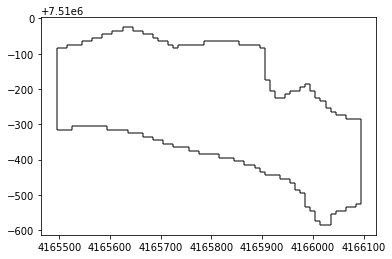

In [273]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
fig, ax = plt.subplots()
for i in out:
    path = Path(i)
    patch = patches.PathPatch(path, facecolor='orange', lw=2, alpha=0.5, capstyle='butt', hatch='/')
    a = patches.FancyArrowPatch(path=patch)
    ax.add_patch(patch)
ax.autoscale_view()

In [275]:
out

[]

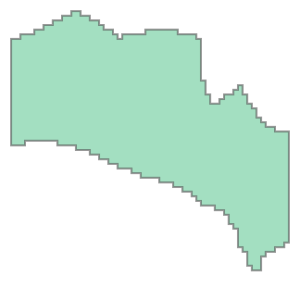

In [248]:
counts.mean()

1.9310344827586208

In [245]:
b = np.array(df['polygon'].apply(lambda r: np.array(r.exterior.coords.xy).T.tolist()).tolist())

In [249]:
b.reshape(-1, 2)

array([[4187755., 7509845.],
       [4187755., 7509855.],
       [4187765., 7509855.],
       ...,
       [4188355., 7509795.],
       [4188355., 7509785.],
       [4188345., 7509785.]])

In [234]:
df['x']

43      4187760.0
44      4187760.0
45      4187760.0
46      4187760.0
47      4187760.0
48      4187760.0
49      4187760.0
50      4187760.0
51      4187760.0
52      4187760.0
99      4187770.0
100     4187770.0
103     4187770.0
104     4187770.0
105     4187770.0
106     4187770.0
107     4187770.0
108     4187770.0
109     4187770.0
110     4187770.0
111     4187770.0
112     4187770.0
113     4187770.0
114     4187770.0
158     4187780.0
159     4187780.0
160     4187780.0
161     4187780.0
163     4187780.0
164     4187780.0
          ...    
3516    4188340.0
3517    4188340.0
3518    4188340.0
3551    4188350.0
3552    4188350.0
3553    4188350.0
3554    4188350.0
3555    4188350.0
3556    4188350.0
3557    4188350.0
3558    4188350.0
3559    4188350.0
3560    4188350.0
3561    4188350.0
3562    4188350.0
3563    4188350.0
3564    4188350.0
3565    4188350.0
3566    4188350.0
3567    4188350.0
3568    4188350.0
3569    4188350.0
3570    4188350.0
3571    4188350.0
3572    41

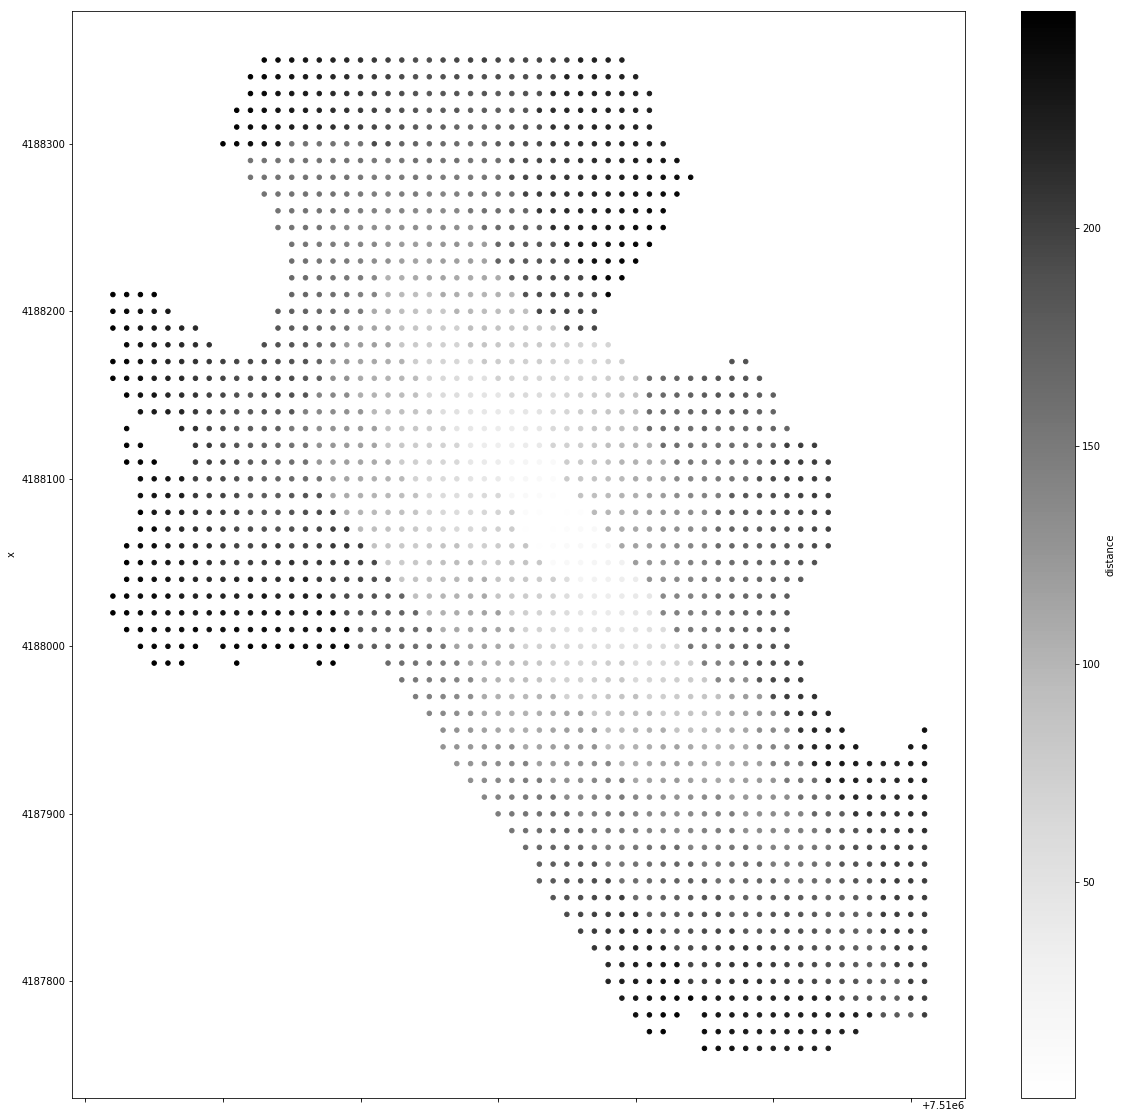

In [215]:
df[df['distance'] < 250].plot('y', 'x', c='distance', kind='scatter', figsize=(20, 20))

In [129]:
#times = np.array(times) - min(times)

In [15]:
transform(PROJ4326, PROJ3857, coords[0][0], coords[0][1])

(4187764.55429232, 7509425.2748477785)

In [16]:
transform(PROJ4326, PROJ3857, coords[1][0], coords[1][1])

(4187764.55429232, 7509430.274847781)

In [17]:
7479725.274847778 - 7480025.274847779

-300.00000000186265

In [18]:
import matplotlib.pyplot as plt

In [19]:
TimeSquare.objects.all().delete()

(4489, {'main_map.TimeSquare': 4489})

In [20]:
for i in tqdm_notebook(range(len(times))):
    obj = TimeSquare()
    obj.foot = times[i]
    coord = coords[i]
    obj.x, obj.y = transform(PROJ4326, PROJ3857, coord[0], coord[1])
    obj.save()